In [1]:
import math 
import numpy as np
from scipy import signal 
import matplotlib.pyplot as plt
from scipy.io.wavfile import write, read
import IPython
import random

In [2]:
def P2R(A, phi):
    return A * ( np.cos(phi) + np.sin(phi) * 1j )

In [3]:
def PreProcessData(xn, frameSize, stepSize):
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    iteration = int(len(temp) // stepSize) - int(frameSize // stepSize) + 1
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = temp[start:end]
        
    return dataSet, temp, len(temp), iteration

In [4]:
def wrapPhase(input_data):
    if (input_data >= 0):
        return math.fmod(input_data + np.pi, 2.0 * np.pi) - np.pi
    else:
        return math.fmod(input_data - np.pi, -2.0 * np.pi) + np.pi

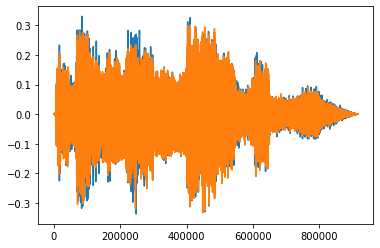

In [5]:
rate, file = read("explosion.wav")

fixed_data0 = file[:, 0]
fixed_data1 = file[:, 1]

data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

numerator = [0.9636527639641732, -1.9273055279283464, 0.9636527639641732]
denominator = [1.0, -1.9259839697318857, 0.9286270861248074]

data0 = signal.lfilter(numerator, denominator, data0)
data1 = signal.lfilter(numerator, denominator, data1)

plt.plot(data0)
plt.plot(data1)
plt.show()

In [6]:
fs = rate

dataSet, data, length, iteration = PreProcessData(data0, 1024, 128)

frameSize = 128
stepSize = 32

output = np.zeros(length)

lastInputPhases = np.zeros(frameSize)
lastOutputPhases = np.zeros(frameSize)

analysisMagnitudes = np.zeros(frameSize//2 + 1)
analysisFrequencies = np.zeros(frameSize//2 + 1)

synthesisMagnitudes = np.zeros(frameSize//2 + 1)
synthesisFrequencies = np.zeros(frameSize//2 + 1)

X_synthesis = np.zeros(frameSize, dtype=complex)

SemiTones = -5
PitchShift = np.power(2.0, SemiTones / 12.0)

In [7]:
for i in range(iteration):
    temp = signal.resample(dataSet[i], 128) * signal.hann(frameSize)
    # temp = dataSet[i]
    
    # Apply FFT
    X = np.fft.fft(temp)

    amplitude_vec = np.abs(X)
    phase_vec = np.angle(X)
    
    for n in range(frameSize//2):
        amplitude = amplitude_vec[n]
        phase = phase_vec[n] 
        
        # Calculate the phase difference in this bin between the last
        # hop and this one, which will indirectly give us the exact frequency
        phaseDiff = phase - lastInputPhases[n]
        
        # Subtract the amount of phase increment we'd expect to see based
        # on the centre frequency of this bin (2 * pi * n / fftSize) for this
        # step size, then wrap to the range -pi to pi
        binCentreFrequency = 2 * np.pi * n / frameSize
        phaseDiff = wrapPhase(phaseDiff - binCentreFrequency * stepSize)
        
        # Find deviation in (fractional) number of bins from the centre frequency
        binDeviation = phaseDiff * frameSize / stepSize / (2 * np.pi)
        
        # Add the original bin number to get the fractional bin where this partial belongs
        analysisFrequencies[n] = n + binDeviation
        
        #  Save the magnitude for later process
        analysisMagnitudes[n] = amplitude
        
        # Save the phase for next hop
        lastInputPhases[n] = phase
    
    # Zero out the synthesis bins, ready for new data
    for n in range(frameSize//2):
        synthesisMagnitudes[n] = 0
        synthesisFrequencies[n] = 0
    
    # Handle the pitch shift, storing frequencies into new bins
    for n in range(frameSize//2):
        newBin = math.floor(n * PitchShift + 0.5)
        
        # gnore any bins that have shifted above Nyquist
        if(newBin <= frameSize//2):
            synthesisMagnitudes[newBin] += analysisMagnitudes[n]
            synthesisFrequencies[newBin] = analysisFrequencies[n] * PitchShift
    
    # Synthesise frequencies into new magnitude and phase values for FFT bins
    for n in range(frameSize//2):
        amplitude = synthesisMagnitudes[n]
        
        binDeviation = synthesisFrequencies[n] - n
        
        phaseDiff = binDeviation * 2 * np.pi * stepSize / frameSize
        
        binCentreFrequency = 2 * np.pi * n / frameSize
        phaseDiff += binCentreFrequency * stepSize
        
        phase = wrapPhase(lastOutputPhases[n] + phaseDiff)
        
        # Final output
        X_synthesis[n] = amplitude * np.cos(phase) + amplitude * np.sin(phase) * 1j
        
        # Mirror the other half spectrum
        if(n > 0 and n < frameSize//2): X_synthesis[frameSize - n] = X_synthesis[n]
        
        lastOutputPhases[n] = phase
    
    # Apply Inverse FFT
    yn = np.fft.ifft(X_synthesis).real * signal.hann(frameSize)
    
    start = i * 128
    end = start + 1024
    
    output[start:end] = output[start:end] + signal.resample(yn, 1024)

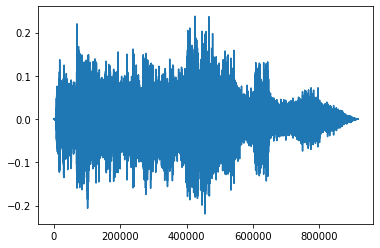

In [8]:
plt.plot(output)
plt.show()

raw = np.array([data0 * 32767.0, data1 * 32767.0]).astype(np.int16).T
write("raw.wav", rate, raw)
IPython.display.display(IPython.display.Audio("raw.wav", rate=rate))

temp = np.array([output * 32767.0, output * 32767.0]).astype(np.int16).T
write("output.wav", rate, temp[:len(raw)] + raw)
IPython.display.display(IPython.display.Audio("output.wav", rate=rate))